## Proyecto individual 2.

# Análisis de datos del mercado de criptomonedas.

####

### Importar las bibliotecas necesarias.

In [1]:
from urllib.request import urlopen
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import pytz
import json
import warnings
warnings.filterwarnings('ignore')

##### Conversión de marcas de tiempo de fecha a formato Unix para las consultas a la API.

In [2]:
# Definir las fechas como tuplas
inicio_fecha = (2018, 1, 1, 0, 0, 0)  # Año, mes, día, hora, minuto, segundo
final_fecha = (2023, 8, 10, 0, 0, 0)  # Año, mes, día, hora, minuto, segundo

# Convertir las tuplas a objetos datetime
fecha_inicio = datetime.datetime(*inicio_fecha)
fecha_final = datetime.datetime(*final_fecha)

# Definir la zona horaria de GMT
zona_horaria = pytz.timezone('GMT')

# Asignar la zona horaria a las fechas
fecha_inicio_con_zona = zona_horaria.localize(fecha_inicio)
fecha_final_con_zona = zona_horaria.localize(fecha_final)

# Obtener los UNIX Timestamp de las fechas con zona horaria
timestamp_inicio = int(fecha_inicio_con_zona.timestamp()) #con estos
timestamp_final = int(fecha_final_con_zona.timestamp())  #con estos

###  Carga de datos

##### - Extracción de datos desde la API, procesamiento y creación del DataFrame.

In [3]:
# Lista de IDs de criptomonedas
crypto_ids = ['axie-infinity', 'ripple', 'chainlink', 'binancecoin', 'solana', 'cardano', 'dogecoin', 'litecoin', 'ethereum', 'bitcoin']

# lista para almacenar los DataFrames
crypto_dfs = []

# ciclo para obtener los datos de la API 
for crypto_id in crypto_ids:
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart/range?vs_currency=usd&from={timestamp_inicio}&to={timestamp_final}&precision=2'
    response = urlopen(url)
    data = json.loads(response.read())

    coins_date = []
    prices = []
    market_caps = []
    total_volumes = []
    
    for entry in data['prices']:
        coins_date.append(entry[0])
        prices.append(entry[1])

    for entry in data['market_caps']:
        market_caps.append(entry[1])

    for entry in data['total_volumes']:
        total_volumes.append(entry[1])      

    # Decodificar las marcas de tiempo UNIX a fechas
    coins_date = pd.to_datetime(coins_date, unit='ms')

    # crea el DataFrame para las criptomonedas selecionadas
    df = pd.DataFrame({
        'Coins_date': coins_date,
        'Price': prices,
        'Market Cap': market_caps,
        'Total volume': total_volumes
        })
    
    # Agrega columnas con el id y el nombre de las criptomonedas
    df.insert(1, 'id', crypto_id)
    
    # Agregar el DataFrame a la lista
    crypto_dfs.append(df)
    
# combina todos los DataFrame en uno solo
coins_df = pd.concat(crypto_dfs, ignore_index=True)     

### Análisis de datos.

##### - Reviso las primeras filas del DataFrame.

In [4]:

coins_df.head()

,Coins_date,id,Price,Market Cap,Total volume
0,2020-11-04,axie-infinity,0.15,7.754756e+06,1.885524e+07
1,2020-11-05,axie-infinity,0.15,7.754756e+06,1.885524e+07
2,2020-11-06,axie-infinity,0.13,7.257185e+06,5.718030e+06
3,2020-11-07,axie-infinity,0.14,7.678065e+06,3.529226e+06
4,2020-11-08,axie-infinity,0.14,7.658840e+06,2.744359e+06


##### Se evidencia que los datos de las columnas "Market Cap" y "Total Volume" están en notación científica.

###### 

In [61]:
coins_df.shape

(18611, 6)

##### - Convierto los números en notación científica a valores de punto flotante (float).

In [8]:
pd.options.display.float_format = '{:,.2f}'.format

In [9]:
coins_df.head()

,Coins_date,id,Price,Market Cap,Total volume
0,2020-11-04,axie-infinity,0.15,"7,754,755.62","18,855,236.28"
1,2020-11-05,axie-infinity,0.15,"7,754,755.62","18,855,236.28"
2,2020-11-06,axie-infinity,0.13,"7,257,184.76","5,718,029.63"
3,2020-11-07,axie-infinity,0.14,"7,678,065.07","3,529,225.76"
4,2020-11-08,axie-infinity,0.14,"7,658,840.35","2,744,359.08"


##### - Reviso los tipos de datos del DataFrame.

In [10]:
coins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18611 entries, 0 to 18610
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Coins_date    18611 non-null  datetime64[ns]
 1   id            18611 non-null  object        
 2   Price         18611 non-null  float64       
 3   Market Cap    18611 non-null  float64       
 4   Total volume  18611 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 727.1+ KB


###### Se evidencia 5 columnas con 18611 filas

# 

##### - Verifico valores faltantes en el DataFrame.

In [11]:
coins_df.isnull().sum()

Coins_date      0
id              0
Price           0
Market Cap      0
Total volume    0
dtype: int64

###### No se evidencia valores faltantes

#

##### - Detección de duplicados en el DataFrame.

In [12]:
coins_df.duplicated().sum()

0

###### No se evidencia valores duplicados

#

##### - Resumen estadístico de los datos.

In [13]:
columns_to_analyze = ["Price", "Market Cap", "Total volume"]

# Agrupar los datos por el campo "Symbol" y calcular estadísticas descriptivas
grouped_stats = coins_df.groupby("id")[columns_to_analyze].describe()

grouped_stats


Price                                                   
                 count      mean       std      min      25%       50%   
id                                                                       
axie-infinity 1,010.00     28.57     37.03     0.13     6.27     10.07  \
binancecoin   2,048.00    166.00    179.45     4.47    15.52     30.96   
bitcoin       2,048.00 20,983.07 16,215.47 3,216.63 8,143.47 14,020.27   
cardano       2,048.00      0.48      0.60     0.02     0.07      0.26   
chainlink     2,048.00      9.00      9.86     0.17     1.14      6.37   
dogecoin      2,048.00      0.06      0.09     0.00     0.00      0.01   
ethereum      2,048.00  1,213.40  1,152.90    83.79   221.09    741.13   
litecoin      2,048.00     98.37     58.04    23.06    55.29     80.79   
ripple        2,048.00      0.52      0.34     0.14     0.30      0.41   
solana        1,217.00     45.64     56.39     0.51     7.84     24.43   

                                  Market Cap                     ...   
                    75%       max      count               mean  ...   
id                                                               ...   
axie-infinity     46.02    159.76   1,010.00   2,038,163,842.69  ...  \
binancecoin      307.48    675.10   2,048.00  26,494,316,728.90  ...   
bitcoin       30,447.84 67,617.02   2,048.00 392,643,520,396.32  ...   
cardano            0.54      2.97   2,048.00  15,477,192,441.01  ...   
chainlink         13.29     51.85   2,048.00   3,948,985,007.85  ...   
dogecoin           0.08      0.68   2,048.00   8,465,693,813.72  ...   
ethereum       1,855.58  4,815.00   2,048.00 141,587,921,157.88  ...   
litecoin         130.06    384.67   2,048.00   6,426,310,711.54  ...   
ripple             0.64      3.40   2,048.00  23,373,690,385.84  ...   
solana            44.50    259.24   1,217.00  14,365,881,907.93  ...   

                                                      Total volume   
                             75%                  max        count   
id                                                                   
axie-infinity   3,401,667,062.97    10,485,977,643.36     1,010.00  \
binancecoin    48,825,673,383.11   110,441,230,385.45     2,048.00   
bitcoin       587,981,125,882.10 1,278,797,895,528.36     2,048.00   
cardano        17,528,257,646.06    95,003,730,487.98     2,048.00   
chainlink       5,389,571,175.74    22,037,403,034.97     2,048.00   
dogecoin       11,250,943,155.16    88,794,768,977.21     2,048.00   
ethereum      222,308,706,381.27   571,665,766,496.09     2,048.00   
litecoin        8,347,910,455.15    25,677,759,329.76     2,048.00   
ripple         28,568,543,214.62   131,653,046,805.29     2,048.00   
solana         14,682,953,331.35    77,427,308,372.13     1,217.00   

                                                                     
                           mean               std              min   
id                                                                   
axie-infinity    275,802,369.19    530,656,650.99     2,744,359.08  \
binancecoin      943,514,432.33  1,555,858,257.20        11,587.67   
bitcoin       25,254,697,746.90 18,573,093,004.81 1,102,262,799.21   
cardano          993,057,639.56  1,799,283,751.51    14,545,306.53   
chainlink        562,247,082.58    736,304,388.20       402,666.11   
dogecoin       1,007,860,843.76  3,244,167,635.31     1,682,405.14   
ethereum      13,269,283,653.70 12,939,850,847.51   549,082,514.93   
litecoin       2,168,364,176.46  2,362,848,461.58   150,448,729.12   
ripple         2,658,707,846.32  3,675,488,128.25   131,492,857.30   
solana           985,418,786.33  1,291,565,471.83       548,910.11   

                                                                      
                            25%               50%               75%   
id                                                                    
axie-infinity     40,308,361.95    106,096,582.64    303,762,038.17  \
binancecoin

#

#####  - Análisis de Outliers

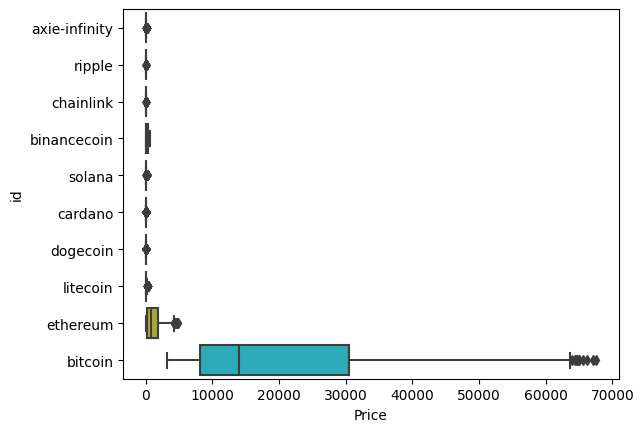

In [27]:
sns.boxplot(data=coins_df,y='id',x='Price');

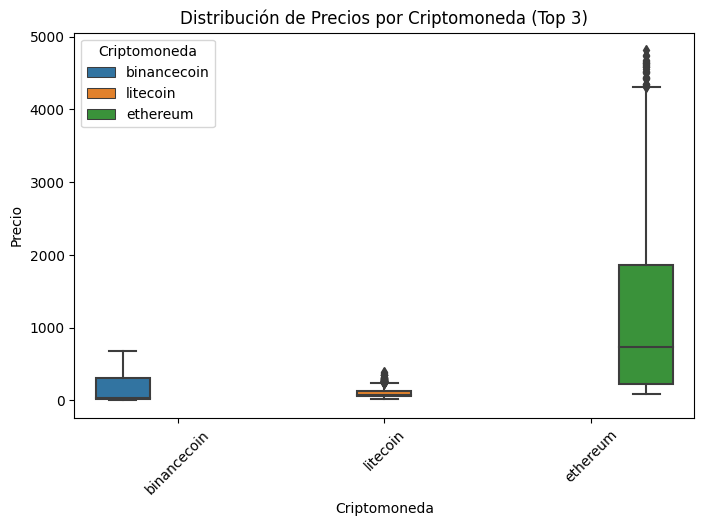

In [58]:
coins_3 = ['ethereum', 'binancecoin', 'litecoin']  # Reemplaza con las criptomonedas que desees

# Filtrar el DataFrame para incluir solo las criptomonedas en la lista top_3_coins
filtered_coins_df = coins_df[coins_df['id'].isin(coins_3)]

# Crear un gráfico de caja con diferentes colores para cada criptomoneda en el top 3
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_coins_df, y='Price', x='id', hue='id')
plt.title('Distribución de Precios por Criptomoneda (Top 3)')
plt.xlabel('Criptomoneda')
plt.ylabel('Precio')
plt.legend(title='Criptomoneda')
plt.xticks(rotation=45)
plt.show()

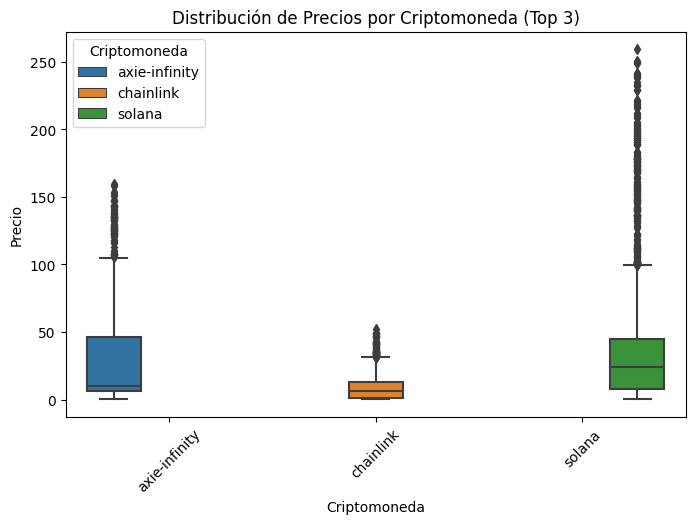

In [59]:
coins_3 = ['solana', 'chainlink', 'axie-infinity']  # Reemplaza con las criptomonedas que desees

# Filtrar el DataFrame para incluir solo las criptomonedas en la lista top_3_coins
filtered_coins_df = coins_df[coins_df['id'].isin(coins_3)]

# Crear un gráfico de caja con diferentes colores para cada criptomoneda en el top 3
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_coins_df, y='Price', x='id', hue='id')
plt.title('Distribución de Precios por Criptomoneda (Top 3)')
plt.xlabel('Criptomoneda')
plt.ylabel('Precio')
plt.legend(title='Criptomoneda')
plt.xticks(rotation=45)
plt.show()

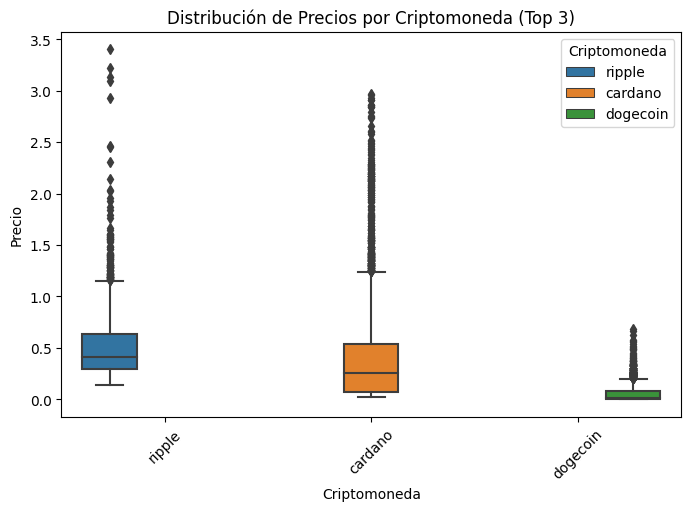

In [60]:
coins_3 = ['dogecoin', 'ripple', 'cardano' ]  # Reemplaza con las criptomonedas que desees

# Filtrar el DataFrame para incluir solo las criptomonedas en la lista top_3_coins
filtered_coins_df = coins_df[coins_df['id'].isin(coins_3)]

# Crear un gráfico de caja con diferentes colores para cada criptomoneda en el top 3
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_coins_df, y='Price', x='id', hue='id')
plt.title('Distribución de Precios por Criptomoneda (Top 3)')
plt.xlabel('Criptomoneda')
plt.ylabel('Precio')
plt.legend(title='Criptomoneda')
plt.xticks(rotation=45)
plt.show()

En el primer gráfico, se pueden observar valores atípicos para Bitcoin. Al dividir los datos de las criptomonedas en varios gráficos, también se pueden identificar valores que podrían considerarse atípicos. Sin embargo, en este caso, estos valores no deberían ser tratados como atípicos en el sentido convencional. Esto se debe a que la variación en los precios de las criptomonedas es extremadamente volátil y puede llevar a que los valores se alejen significativamente de la norma. Por lo tanto, estos valores pueden ser una manifestación normal de la naturaleza altamente cambiante de los precios de las criptomonedas.  

# 

#

### Graficos, Análisis y Concluciones

##### -Voy a crear una tabla pivote con el valor promedio por año.

In [14]:
# Crear una columna para el año
coins_df['Year'] = coins_df['Coins_date'].dt.year

# Crear la tabla pivote con el valor medio por año para cada criptomoneda
pv = pd.pivot_table(coins_df, index='Year', columns='id', values='Price', aggfunc='mean')

pv

id,axie-infinity,binancecoin,bitcoin,cardano,chainlink,dogecoin,ethereum,litecoin,ripple,solana
Year,,,,,,,,,,
2018,NaN,11.20,"7,596.47",0.21,0.41,0.00,484.47,105.85,0.67,NaN
2019,NaN,20.00,"7,362.38",0.06,1.53,0.00,181.18,69.42,0.31,NaN
2020,0.49,21.26,"11,052.20",0.09,7.40,0.00,305.64,55.97,0.26,1.70
2021,45.88,377.46,"47,441.73",1.50,26.63,0.20,"2,775.13",185.97,0.87,79.72
2022,28.35,325.29,"28,296.80",0.65,10.38,0.10,"1,995.88",80.30,0.52,58.40
2023,7.82,289.63,"26,232.80",0.35,6.82,0.08,"1,751.34",89.23,0.48,21.09


##### -Gráfico de Líneas para el valor promedio por año de cada criptomoneda

<Figure size 1500x800 with 0 Axes>

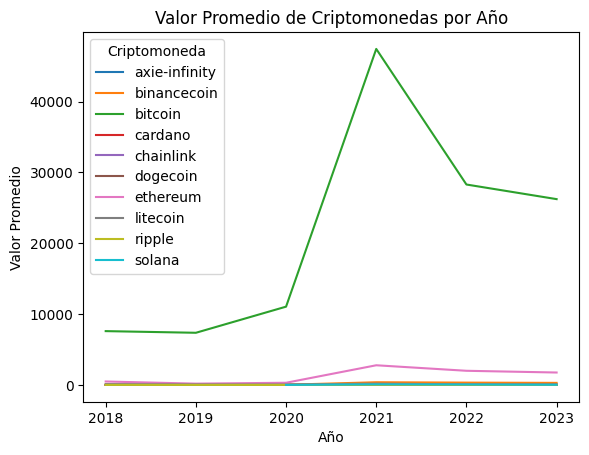

In [62]:
# Gráfico de Líneas valor promedio por año para cada criptomoneda
plt.figure(figsize=(15, 8))
pv.plot(kind='line')
plt.title('Valor Promedio de Criptomonedas por Año')
plt.xlabel('Año')
plt.ylabel('Valor Promedio')
plt.legend(title='Criptomoneda')
plt.show()

En el gráfico se observa una gran diferencia en los precios de las criptomonedas, especialmente en el caso de Bitcoin, cuyo valor es notablemente superior en comparación con las otras criptomonedas.

#

#

##### -Gráfico de líneas que muestra la evolución del volumen total de operaciones de criptomonedas

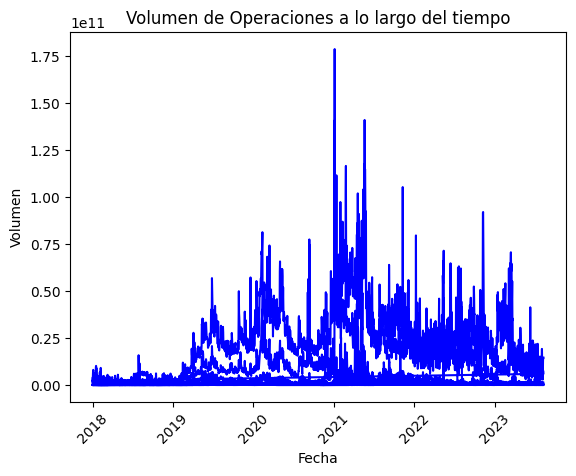

In [78]:
plt.plot(coins_df['Coins_date'], coins_df['Total volume'], color='blue')
plt.title('Volumen de Operaciones a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.show()

El gráfico ilustra el volumen total de operaciones de criptomonedas a lo largo de los años analizados. Se observa claramente que durante los años 2021 y 2022, el volumen de operaciones experimentó un aumento considerable. Además, se aprecia una marcada disminución en el volumen durante el año 2023. Estos datos indican una tendencia de crecimiento seguida por una contracción en el volumen de operaciones a lo largo de los años estudiados. Esta visualización proporciona insights valiosos sobre los patrones de actividad en el mercado de criptomonedas y sugiere momentos de mayor y menor interés por parte de los inversores.

#

##### -Conjunto de Gráficos en pares(pair plot), Cada gráfico en el conjunto muestra la relación entre las variables Price, Total volume y Market Cap. 

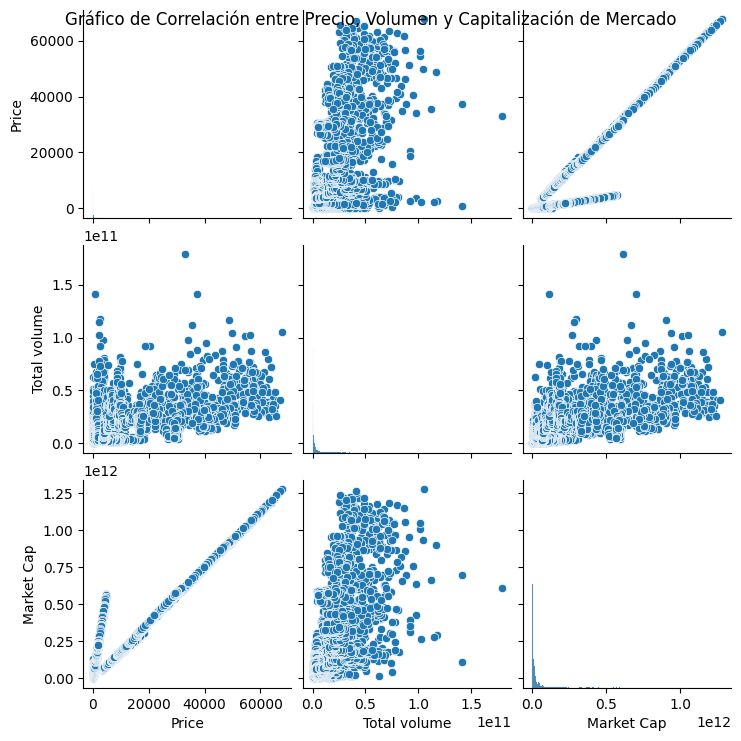

In [79]:
sns.pairplot(coins_df[['Price', 'Total volume', 'Market Cap']])
plt.suptitle('Gráfico de Correlación entre Precio, Volumen y Capitalización de Mercado')
plt.show()

##### -Mapa de calor que representa la matriz de correlación entre las variables numéricas del DataFrame.

Text(0.5, 1.0, 'Matriz de Correlación')

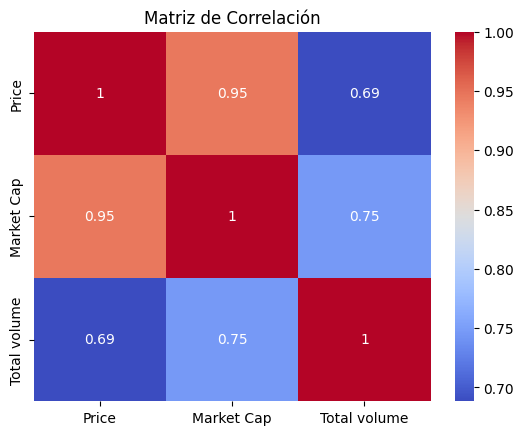

In [80]:
numeric_columns = coins_df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_columns.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')

En el gráfico se puede observar la correlación existente entre el Market Cap (Capitalización de Mercado) y el precio. Esto revela la fuerte dependencia que existe entre estas dos variables. La intensidad de los colores en las celdas coloreadas del mapa de calor indica el grado de correlación entre ambas variables.

##### -Creacion del csv para el Dashboard

In [ ]:
coins_df.to_csv('Historico_coins.csv', index=False)

##### Conclusiones del Análisis

En el contexto del auge de las criptomonedas y el creciente interés de inversores y empresas en este campo, se realizó un análisis con el propósito de comprender el comportamiento de las criptomonedas. Dada la amplia variedad de criptomonedas disponibles, cada una con características y tecnologías diversas, este análisis se planteó como un medio para obtener una visión detallada de las tendencias y relaciones entre sus variables clave.

El presente análisis proporciona una perspectiva del mundo de las criptomonedas. Se han identificado patrones, tendencias y relaciones significativas entre distintas variables, lo que ha permitido obtener una visión de su funcionamiento. A continuación, se presentan las principales conclusiones derivadas de este análisis:

Variación en los Precios y Capitalización: Se evidencia que los precios de las criptomonedas varían considerablemente, con el Bitcoin que se destaca como una criptomoneda con un precio notablemente más alto en comparación con otras. Además, se observa una relación intrínseca entre los precios y la capitalización de mercado, lo que sugiere que la capitalización de mercado es una variable clave en la determinación de los precios.

Relación entre Precios y Volumen: El análisis revela que existe cierta relación entre los precios de las criptomonedas y el volumen total de operaciones. Esto sugiere que los movimientos de precios pueden estar influenciados por la actividad comercial y la demanda en el mercado.

Tendencias Temporales: Se observan variaciones significativas en los precios a lo largo del tiempo. En particular, se destaca un incremento pronunciado en los precios durante el año 2021, seguido de un período de disminución en 2022 y una mayor volatilidad y variación a la baja en lo corrido del 2023. Esta volatilidad sugiere que los precios de las criptomonedas son altamente cambiantes y pueden estar sujetos a diversos factores.

Impacto del Mercado: El análisis pone en evidencia la fuerte dependencia de los precios de las criptomonedas en relación con la capitalización de mercado. Este hallazgo sugiere que las tendencias y los movimientos en el mercado de capitalización pueden influir significativamente en los precios.

Volatilidad y Cambios Bruscos: La variabilidad y las variaciones drásticas en los precios de las criptomonedas a lo largo de los años subrayan la volatilidad característica de este mercado. Esta volatilidad puede ser atribuida a una serie de factores, incluyendo eventos económicos, regulaciones y percepciones del mercado.

En resumen, este análisis revela que el comportamiento de las criptomonedas es complejo y está influenciado por diversos factores interconectados. La volatilidad en los precios y la fuerte dependencia de variables como el volumen y la capitalización hacen que el mercado de las criptomonedas sea altamente dinámico y desafiante de predecir. Estas conclusiones brindan una base para comprender mejor el mundo de las criptomonedas y tomar decisiones informadas en un entorno en constante evolución.